In [1]:
# Imports Required Libraries
import json
import os
import time

from math import ceil
from math import floor

from matplotlib import pyplot as plt

from common import batch_and_test
from common import async_batch_and_test

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [2]:
def batch_by_memory_size(max_batch_size, test_file_directory, raw_json_data_test_file):
    '''
    Returns 

    Keyword Arguments:
    max_batch_size --
    raw_json_data_test_file -- 
    '''
    
    batches_of_content = 1
    batched_contents = []
    
    with open(os.path.join(test_file_directory, raw_json_data_test_file), 'rb') as file:
        content = json.load(file)
        
        size_of_content = os.path.getsize(raw_json_data_test_file)
        length_of_content = len(content)
        size_of_row = ceil(size_of_content / length_of_content)
        rows_per_batch = floor(max_batch_size / size_of_row)

        print(f'Total Size of Data: {size_of_content} Bytes')
        print(f'Total Rows of Data: {length_of_content}')
        print(f'Approximate Size of Row: {size_of_row} Bytes')
        print(f'Rows Per Batch: {rows_per_batch}')
        
        if size_of_content > max_batch_size:
            batches_of_content = ceil(length_of_content / rows_per_batch)
            
            print(f'Total Batches of Data: {batches_of_content}')
            
            for batch_number in range(batches_of_content):
                
                batch_of_content = []
                
                if batch_number != batches_of_content - 1:
                    batch_of_content = content[
                        (batch_number * rows_per_batch):(((batch_number + 1) * rows_per_batch))]
                else:
                    batch_of_content = content[
                        (batch_number * rows_per_batch):]
                    
                batched_contents.append(batch_of_content)
                
        else:
            batched_contents.append(content)
            
    return batched_contents

In [3]:
def compare_execution_times(sync_time, async_time):
    '''
    Returns
    
    Keyword Arguments:
    sync_time1 -- 
    async_time2 --
    '''
    
    sync_time = str(sync_time)
    sync_time = round(float(sync_time[1:len(sync_time) - 1]), 3)

    async_time = str(async_time)
    async_time = round(float(async_time[1:len(async_time) - 1]), 3)
        
    time_diff = round((sync_time - async_time), 3)
    speed_incr = round((((sync_time - async_time) / abs(sync_time)) * 100), 3)
    
    res = {'sync_time': [sync_time],
           'async_time': [async_time],
           'time_diff': [time_diff],
           'speed_incr': [speed_incr]
    }
    
    res_msg = (
        f'\n'
        f'Time To Completion: \n'
        f'\tSynchronous = {sync_time} Seconds \n'
        f'\tAsynchronous = {async_time} Seconds \n'
        f'\tDifference = {time_diff} Seconds \n'
        f'\tSpeed Increase = {speed_incr}% \n'
    )
    
    return res, res_msg

In [4]:
def merge_execution_times_comparisons(time_comp_res1, time_comp_res2):
    '''
    Returns
    
    Keyword Arguments:
    sync_time1 -- 
    async_time2 -- 
    '''
    
    merged_time_comps_res = {
        'sync_time': time_comp_res1.get('sync_time') + time_comp_res2.get('sync_time'),
        'async_time': time_comp_res1.get('async_time') + time_comp_res2.get('async_time'), 
        'time_diff': time_comp_res1.get('time_diff') + time_comp_res2.get('time_diff'), 
        'speed_incr': time_comp_res1.get('speed_incr') + time_comp_res2.get('speed_incr')
    }
    
    return merged_time_comps_res

In [5]:
def plot_execution_times(time_comps_res):
    '''
    Returns
    
    Keyword Arguments:
    time_comps_res -- 
    '''
    
    keys = list(time_comps_res.keys())
    
    colors = ['black', 'blue', 'orange', 'red']
    labels = ['Synchronous Execution Time', 
              'Asynchronous Execution Time', 
              'Execution Time Difference', 
              '% Speed Increase']
    
    exc_spd_fig, (ax1, ax2) = plt.subplots(2, 1)
    exc_spd_fig.suptitle('Execution Speed Comparisons')

    for index in range(len(keys) - 1):
        ax1.plot(time_comps_res.get(keys[index]), 
                 color = colors[index], 
                 marker = '.',
                 label = labels[index])
    

    
    ax1.set_xlabel('Test #')
    ax1.set_ylabel('Time In Seconds')
    ax1.legend(loc = 'upper left')
    ax1.grid()

    ax2.plot(time_comps_res.get(keys[len(keys) - 1]), 
             color = colors[len(colors) - 1], 
             marker = '.',
             label = labels[len(labels) - 1])
    
    ax2.set_xlabel('Test #')
    ax2.set_ylabel('% Speed Increase')
    ax2.grid()
    
    #test_nums = [0, 1, 2, 3, 4, 5]
    #ax2_annotations = list(zip(time_comps_res.get(keys[len(keys) - 1]), test_nums))
    
    #for annotation in ax2_annotations:
    #    ax2.annotate(text = str(annotation), xy = annotation)

    plt.show()

In [6]:
async def testing(rows_per_batch):
    '''
    Runs all tests and prints out their results in a synchronous fashion
    '''
    
    test_list = [
        (0, '.', 'sample_raw_json_1_row_v1.json'),
        (1, '.', 'sample_raw_json_1_row_v2.json'),
        (2, '.', 'sample_raw_json_10_rows.json'),
        (3, '.', 'sample_raw_json_100_rows.json'),
        (4, '.', 'sample_raw_json_1000_rows.json'),
        (5, '.', 'sample_raw_json_10000_rows.json'),
    ]
    
    time_comps_res = {}
    
    for test in test_list:
        print(f'----- {test[1]} -----')
        sync_res, sync_time = batch_and_test(rows_per_batch, test[0], test[1], test[2])
        async_res, async_time = await async_batch_and_test(rows_per_batch, test[0], test[1], test[2])
        
        time_comp_res, time_comp_msg = compare_execution_times(sync_time, async_time)
        
        if not time_comps_res:
            time_comps_res.update(time_comp_res)

        else:
            time_comps_res = merge_execution_times_comparisons(time_comps_res, time_comp_res)
        
        print(sync_res)
        print(async_res)
        print(time_comp_msg)
    
    plot_execution_times(time_comps_res)

In [7]:
async def main():
    
    await testing(500)

----- . -----
{'cnt_expctd': 0, 'cnt_actl': 0, 'prob_passed': True, 'prob_invld_preds': [], 'busns_out_passed': True, 'busns_out_invld_preds': [], 'in_var_passed': True, 'in_var_invld_preds': []}
{'cnt_expctd': 0, 'cnt_actl': 0, 'prob_passed': True, 'prob_invld_preds': [], 'busns_out_passed': True, 'busns_out_invld_preds': [], 'in_var_passed': True, 'in_var_invld_preds': []}

Time To Completion: 
	Synchronous = 0.059 Seconds 
	Asynchronous = 0.026 Seconds 
	Difference = 0.033 Seconds 
	Speed Increase = 55.932% 

----- . -----
{'cnt_expctd': 0, 'cnt_actl': 0, 'prob_passed': True, 'prob_invld_preds': [], 'busns_out_passed': True, 'busns_out_invld_preds': [], 'in_var_passed': True, 'in_var_invld_preds': []}
{'cnt_expctd': 0, 'cnt_actl': 0, 'prob_passed': True, 'prob_invld_preds': [], 'busns_out_passed': True, 'busns_out_invld_preds': [], 'in_var_passed': True, 'in_var_invld_preds': []}

Time To Completion: 
	Synchronous = 0.023 Seconds 
	Asynchronous = 0.019 Seconds 
	Difference = 0.004 S

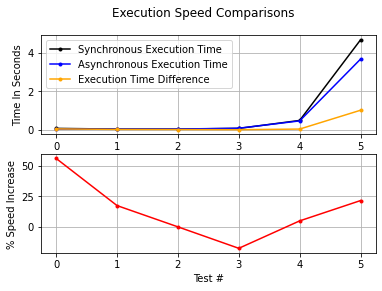

In [8]:
if __name__ == "__main__":  
    await main()